# Cover Image

In [2]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from myUtils import convert_ode_parameters,  calc_critical_treatment_threshold, calc_critical_treatment_interval
from odeModels import LotkaVolterraModel
from plotUtils import PlotDrug, PlotSimulation


In [3]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['N0'] = odeParamDic['n0']

In [4]:
print(plt.rcParams["figure.figsize"])

[8.0, 6.0]


In [5]:
# Variation of threshold with critical interval

tau_values = np.linspace(0, 160, 100)
n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]

In [6]:
def calc_ttp(params, n_crit, interval):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

In [7]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.ticker import MaxNLocator

dx, dy = 1, 0.01
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
# ttp_values = vectorized_calc_ttp(
#     params = odeParamDic, n_crit = crit_n_grid,
#     interval = tau_grid
# )

# with open('data/ttp_arrayb.pkl', 'wb') as file:
#     pickle.dump(ttp_values, file)

In [8]:
with open('data/ttp_array.pkl', 'rb') as file:
    # Use pickle.load() to deserialize and load the array
    ttp_values = pickle.load(file)
ttp_values = ttp_values[:-1, :-1]

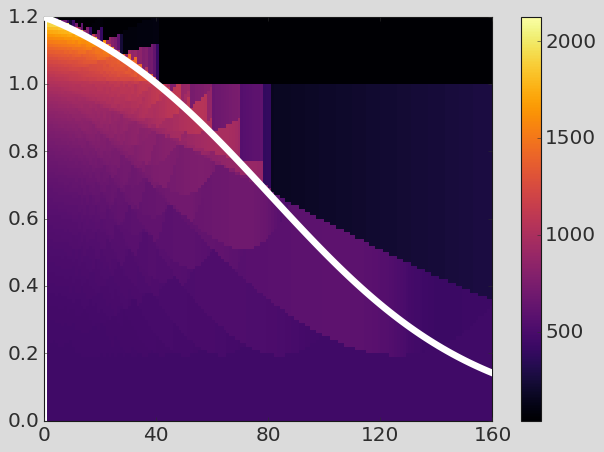

In [14]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('inferno'), norm=None)  #LogNorm(vmin=200, vmax=2000)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 6, zorder=5, color='w', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, 160); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold_inv.jpg"); plt.show()

In [116]:
print(odeParamDic)
odeParamDic2 = convert_ode_parameters(n0=0.375, rFrac=0.001, cost=0, turnover=0.)
odeParamDic2['N0'] = odeParamDic2['n0']


{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075, 'N0': 0.75}


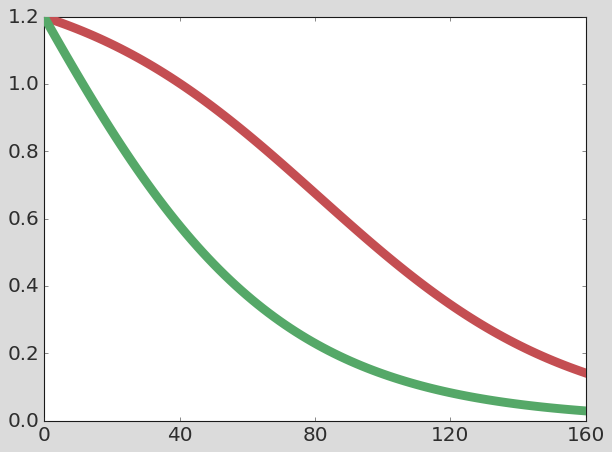

In [117]:

fig, ax = plt.subplots()


n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r'); 

n_stars2 = [calc_critical_treatment_threshold(tau=t,**odeParamDic2)/odeParamDic2['N0'] for t in tau_values]
ax.plot(tau_values, n_stars2, linewidth = 8, zorder=5, color='g'); 

ax.set_xlim(0, np.max(tau_values)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.show()

In [184]:
dx, dy = 2, 0.02
# dx, dy = 40, 0.4

crit_n_grid2, tau_grid2 = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp2 = np.vectorize(calc_ttp)
# ttp_values2 = vectorized_calc_ttp2(
#     params = odeParamDic2, n_crit = crit_n_grid2,
#     interval = tau_grid2
# )

# with open('data/ttp_array2.pkl', 'wb') as file:
#     pickle.dump(ttp_values2, file)

In [185]:
with open('data/ttp_array2.pkl', 'rb') as file:
    # Use pickle.load() to deserialize and load the array
    ttp_values2 = pickle.load(file)
ttp_values2 = ttp_values2[:-1, :-1]

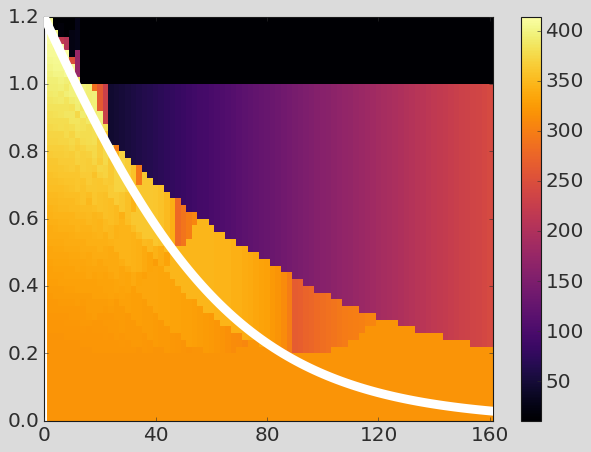

In [191]:


fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid2, crit_n_grid2, ttp_values2, 
                   cmap=plt.get_cmap('inferno'), norm=None, alpha=1)
fig.colorbar(im, ax=ax, alpha=0.1); #ax.set_title('TTP of Patient 25')

n_stars2 = [calc_critical_treatment_threshold(tau=t,**odeParamDic2)/odeParamDic2['N0'] for t in tau_values]
ax.plot(tau_values, n_stars2, linewidth = 8, zorder=5, color='w', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid2)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold2.jpg"); plt.show()

In [128]:
print(odeParamDic)
odeParamDic3 = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0.08)
odeParamDic3['N0'] = odeParamDic3['n0']


{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075, 'N0': 0.75}


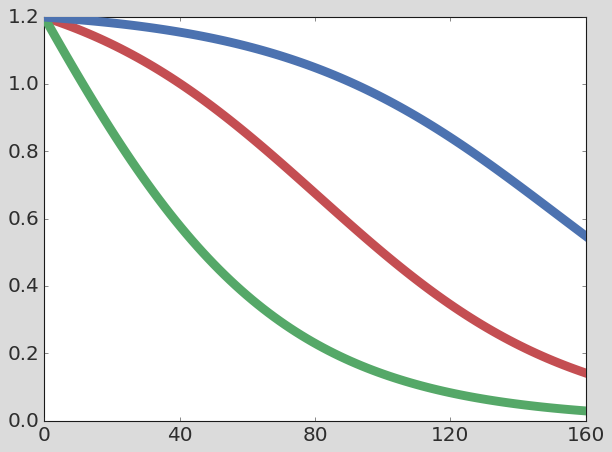

In [129]:

fig, ax = plt.subplots()


n_stars = [calc_critical_treatment_threshold(tau=t,**odeParamDic)/odeParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r'); 

n_stars2 = [calc_critical_treatment_threshold(tau=t,**odeParamDic2)/odeParamDic2['N0'] for t in tau_values]
ax.plot(tau_values, n_stars2, linewidth = 8, zorder=5, color='g'); 

n_stars3 = [calc_critical_treatment_threshold(tau=t,**odeParamDic3)/odeParamDic3['N0'] for t in tau_values]
ax.plot(tau_values, n_stars3, linewidth = 8, zorder=5, color='b'); 

ax.set_xlim(0, np.max(tau_values)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.show()

In [96]:
dx, dy = 2, 0.02
# dx, dy = 40, 0.4

crit_n_grid3, tau_grid3 = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp3 = np.vectorize(calc_ttp)
ttp_values3 = vectorized_calc_ttp2(
    params = odeParamDic3, n_crit = crit_n_grid3,
    interval = tau_grid3
)

with open('data/ttp_array3.pkl', 'wb') as file:
    pickle.dump(ttp_values3, file)

In [130]:
with open('data/ttp_array3.pkl', 'rb') as file:
    # Use pickle.load() to deserialize and load the array
    ttp_values3 = pickle.load(file)
ttp_values3 = ttp_values3[:-1, :-1]

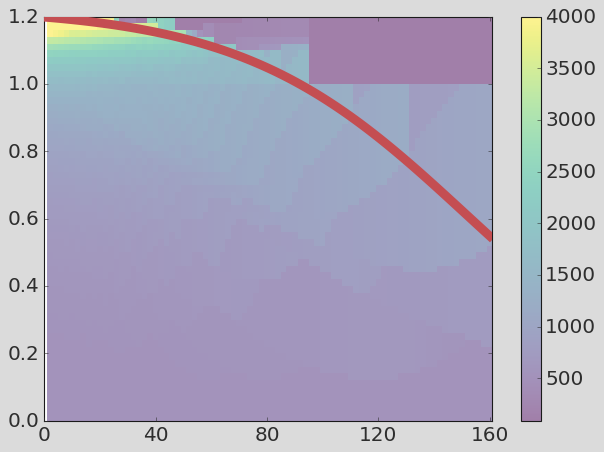

In [131]:


fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid3, crit_n_grid3, ttp_values3, 
                   cmap=plt.get_cmap('viridis'), norm=None, alpha=0.5)
fig.colorbar(im, ax=ax, alpha=0.1); #ax.set_title('TTP of Patient 25')

n_stars3 = [calc_critical_treatment_threshold(tau=t,**odeParamDic3)/odeParamDic3['N0'] for t in tau_values]
ax.plot(tau_values, n_stars3, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid3)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold3.pdf"); plt.show()

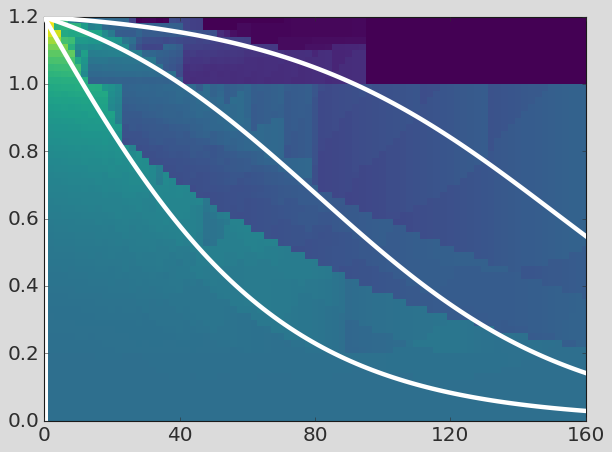

In [206]:
# Normalize ttp_values, ttp_values2, and ttp_values3
norm_ttp_values = ttp_values / np.max(ttp_values)
norm_ttp_values2 = ttp_values2 / np.max(ttp_values2)
norm_ttp_values3 = ttp_values3 / np.max(ttp_values3)

# Sum the normalized values
sum_ttp_values = norm_ttp_values + norm_ttp_values2 + norm_ttp_values3
# sum_ttp_values = ttp_values2 + ttp_values3

fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid3, crit_n_grid3, sum_ttp_values, 
                   cmap=plt.get_cmap('viridis'), norm=None)
# fig.colorbar(im, ax=ax, alpha=0.1); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 4, zorder=5, color='w'); 
ax.plot(tau_values, n_stars2, linewidth = 4, zorder=5, color='w'); 
ax.plot(tau_values, n_stars3, linewidth = 4, zorder=5, color='w'); 

ax.set_xlim(0, 160); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold23.jpg"); plt.show()

In [ ]:
def calc_result(params, n_crit, interval):
    arg = n_crit
    model = LotkaVolterraModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=4000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max(), int(model.resultsDf.DrugConcentration.iloc[-1] > 0)

dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_result)
ttp_values, drug_values = vectorized_calc_ttp(
    params = odeParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
drug_values = drug_values[:-1, :-1]

# Create custom colormap
cmap_red = plt.get_cmap('Reds')
cmap_green = plt.get_cmap('Greens')

cmap_combined = np.zeros((ttp_values.shape[0], ttp_values.shape[1], 3))
for i in range(ttp_values.shape[0]):
    for j in range(ttp_values.shape[1]):
        if drug_values[i, j] == 1:
            cmap_combined[i, j, :] = cmap_green(ttp_values[i, j] / np.max(ttp_values))[:3]
        else:
            cmap_combined[i, j, :] = cmap_red(ttp_values[i, j] / np.max(ttp_values))[:3]

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='k', label = 'Optimal\nThreshold'); 

im = ax.imshow(cmap_combined, origin='lower', extent=[tau_grid.min(), tau_grid.max(), crit_n_grid.min(), crit_n_grid.max()])
# fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.set_xlim(tau_grid.min(), tau_grid.max())
ax.set_ylim(crit_n_grid.min(), crit_n_grid.max())
ax.set_aspect(100)
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/lotka_volterra_model_threshold_binary.pdf"); plt.show()